In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
using TrajOptPlots
const MOI = MathOptInterface
using Random
using Plots
using Rotations
include("quadruped.jl")
include("sparseblocks.jl")
include("quadratic_cost.jl")
include("terrain.jl")
include("nlp.jl")
include("moi.jl")

  Activating environment at `~/Desktop/16745_OCRL/Project/Optimal-Control-Project/Project.toml`


WebIO._IJuliaInit()

solve

## Dynamics Models

In [2]:
include("simple_quadruped.jl")
full_model = UnitreeA1()
n,m = state_dim(full_model), control_dim(full_model)
mvis = initialize_visualizer(full_model);
model = simplifyQuadruped(full_model)
n,m = state_dim(model), control_dim(model);

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/astutt/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


## Reference Trajectory & Contact Sequence

true
true


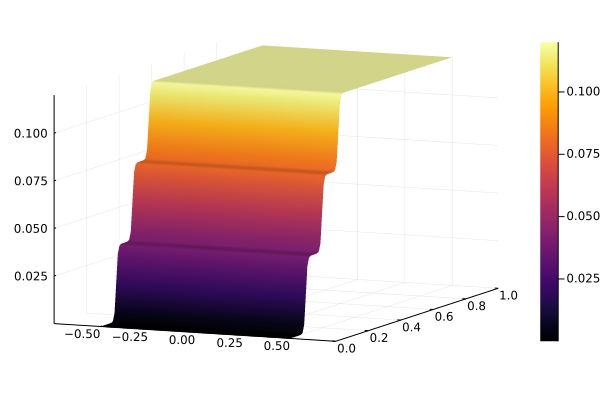

In [253]:
include("ref_trajectory.jl")
include("gait.jl")
include("terrain.jl")

# Discretization
tf = 4.9
dt = 0.1
N = Int(ceil(tf/dt)) + 1
times = range(0,tf, length=N);

# Contact Sequence
#M = 5 # step length
M = 8
contact_sched = contact_sequence_trot(times, M)

# Reference Trajectory
Xref,Uref = reference_trajectory(model, times, contact_sched, M, terrain, xterm=0.2);


# Terrain map
# terrain = FlatTerrain();
# terrain = RampTerrain(0.2, 0.2);
terrain = StepTerrain(3, .1, .02, 10);

# Unit test: terrain slope matches result from ForwardDiff
jacx = ForwardDiff.derivative(x->getHeight(terrain, x, 0.2), 0.2)
jacy = ForwardDiff.derivative(y->getHeight(terrain, 0.2, y), 0.2)
gx, gy = getSlope(terrain, 0.2, 0.2)
println(gx ≈ jacx)
println(gy ≈ jacy)
plotTerrain(terrain)


## Define NLP for IPOPT

In [245]:
include("moi.jl")
include("nlp.jl")
include("nlp_cost.jl")
include("nlp_constraint.jl")

# Define cost function

Q = Diagonal([10; 10; 10; fill(1.0, 4); fill(10.0, 12); 10; 10; 10; fill(1.0, 3); fill(1.0, 12)]);
#Q = Diagonal([10; 10; 10; fill(1.0, 4); fill(10.0, 12); 10; 10; 10; fill(1.0, 3); fill(0.0, 12)]); # converges, alright



# let's try increasing body pos z penalty a bit
#Q = Diagonal([10; 10; 10; fill(1.0, 4); fill(10.0, 12); 10; 10; 10; fill(1.0, 3); fill(1.0, 12)]); # body height goes really low

#Q = Diagonal([10; 10; 10; fill(1.0, 4); fill(15.0, 12); 10; 10; 10; fill(1.0, 3); fill(0.5, 12)]); # doesn't converge

# weird, increasing foot vel penalty helped, but body height is even lower :(
#Q = Diagonal([10; 10; 10; fill(1.0, 4); fill(15.0, 12); 10; 10; 10; fill(1.0, 3); fill(1.0, 12)]);

# adding a penalty on foot vel helped a bit
# Q = Diagonal([10; 10; 10; fill(1.0, 4); fill(15.0, 12); 10; 10; 10; fill(1.0, 3); fill(0.5, 12)]);

# Q = Diagonal([10; 10; 10; fill(1.0, 4); fill(10.0, 12); 10; 10; 10; fill(1.0, 3); fill(0.0, 12)]); # paul's
# Q = Diagonal([1; 10; fill(1.0, 5); fill(0, 12); 1; 10; fill(1.0, 4); fill(0, 12)]); # orig bad
R = Diagonal(fill(1.0,12))

Qf = Q;
obj = map(1:N-1) do k
    LQRCost(Q,R,Xref[k],Uref[k])
end
push!(obj, LQRCost(Qf, R, Xref[N], Uref[N-1]))

# Unit test: constraint Jacobian matches result from ForwardDiff
# let
#     nlp = HybridNLP(model, obj, tf, N, M, Xref[1], Xref[end], contact_sched, terrain, use_sparse_jacobian=true);
#     Random.seed!(1)
#     Xguess = [x + 0.1*randn(length(x)) for x in Xref]
#     Uguess = [u + 0.1*randn(length(u)) for u in Uref]
#     Z0 = packZ(nlp, Xguess, Uguess);
#     initialize_sparsity!(nlp)
#     rc = getrc(nlp.blocks)
#     r = [t[1] for t in rc]
#     c = [t[2] for t in rc]
#     jacvec = zeros(length(rc))
#     jac_c!(nlp, jacvec, Z0)
#     jac = sparse(NonzerosVector(jacvec, nlp.blocks));
    
#     jac_n = ForwardDiff.jacobian(x->eval_c!(nlp, zeros(eltype(x), num_duals(nlp)), x), Z0)
#     for i = 1:5
#         println(jac[nlp.cinds[i],:] ≈ jac_n[nlp.cinds[i],:])
#     end
# end

# Define the NLP
nlp = HybridNLP(model, obj, tf, N, M, Xref[1], Xref[end], contact_sched, terrain, use_sparse_jacobian=true);
Random.seed!(1)
Xguess = [x + 0.1*randn(length(x)) for x in Xref]
Uguess = [u + 0.1*randn(length(u)) for u in Uref]
Z0 = packZ(nlp, Xguess, Uguess);

## Solve NLP

In [239]:
Z_sol, solver = solve(Z0, nlp, c_tol=1e-6, tol=1e-4, max_iter=1500)

Creating NLP Block Data...
Creating Ipopt...
Adding constraints...
starting Ipopt Solve...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   158956
Number of nonzeros in inequality constraint Jacobian.:     7700
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2438
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1987
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:      100
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:       

([2.757175364133657e-16, -1.7632292461167212e-15, 0.2800000000824457, 1.0000000000000078, -5.093957169948316e-16, 3.0944250970369285e-17, -1.1682474511542364e-16, 0.18299999999379135, 0.04699999999999479, 0.041291816145063644  …  -2.025598489163121e-16, 1.3453826579380648e-15, 6.355326871890697e-15, 3.603642688773292e-11, 3.8655367199707477e-16, 6.2995175940576724e-15, 3.603593545373249e-11, -2.586671728559667e-16, 2.258778627881214e-16, -4.694884001647932e-16], Ipopt.Optimizer)

## Simulation

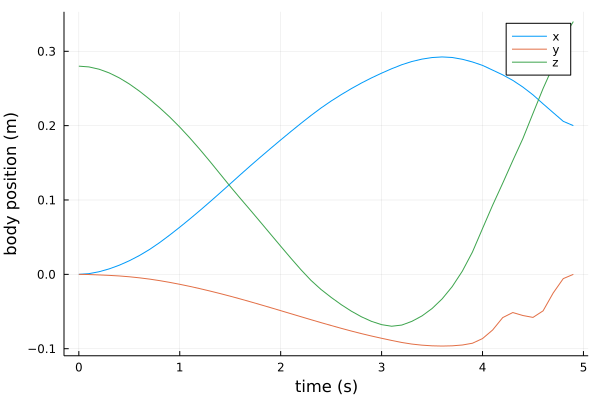

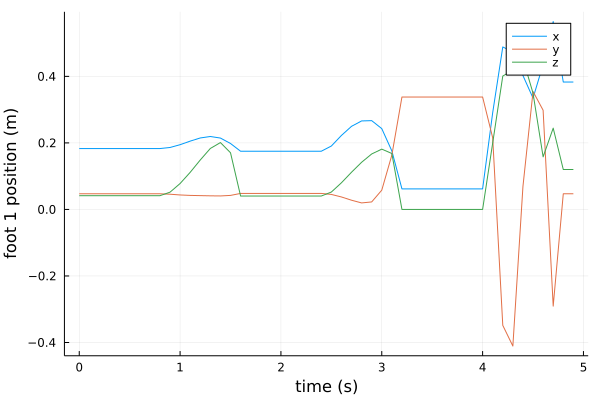

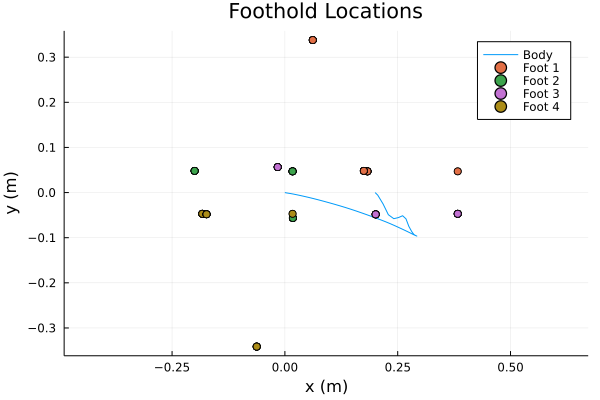

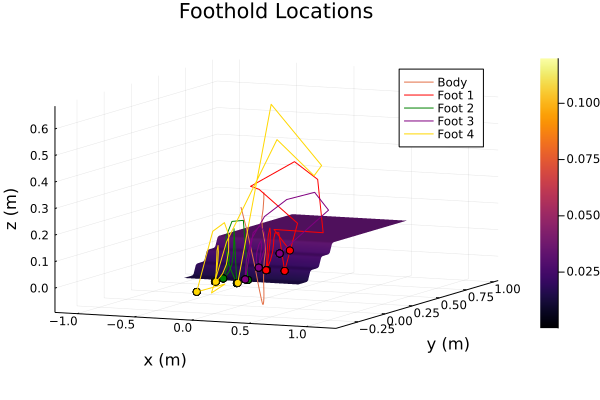

In [256]:
Xsol,Usol = unpackZ(nlp,Z_sol)  # Optimal solution
# Xsol,Usol = unpackZ(nlp,Z0)     # Initial guess
#Xsol,Usol = Xref, Uref          # Reference solution

Xmat = zeros(N, n)
for k = 1:N
    Xmat[k,:] = Xsol[k]
end
Umat = zeros(N-1, m)
for k = 1:N-1
    Umat[k,:] = Usol[k]
end
f1 = nlp.modes[1,:] .== 1
f2 = nlp.modes[2,:] .== 1
f3 = nlp.modes[3,:] .== 1
f4 = nlp.modes[4,:] .== 1

# State/input variables vs time
foot = 1 # Select which foot to plot
display(plot(nlp.times, Xmat[:,1:3], label = ["x" "y" "z"], xlabel="time (s)", ylabel="body position (m)"))
display(plot(nlp.times, Xmat[:,(8:10).+(foot-1)*3], label = ["x" "y" "z"], xlabel="time (s)", ylabel="foot 1 position (m)"))
# foot velocity # display(plot(nlp.times, Xmat[:,(26:28).+(foot-1)*3], label = ["x" "y" "z"], xlabel="time (s)", ylabel="foot 1 vel (m)"))
# display(plot(nlp.times[1:N-1], Umat[:,4:6.+(foot-1)*3], label = ["x" "y" "z"], xlabel="time (s)", ylabel="force (N)"))

# 2D foothold locations
plot(Xmat[:,1], Xmat[:,2], xlabel="x (m)", ylabel="y (m)", label = "Body")
scatter!(Xmat[f1,8], Xmat[f1,9], label = "Foot 1")
scatter!(Xmat[f2,11], Xmat[f2,12], label = "Foot 2")
scatter!(Xmat[f3,14], Xmat[f3,15], label = "Foot 3")
display(scatter!(Xmat[f4,17], Xmat[f4,18], label = "Foot 4", title="Foothold Locations", aspect_ratio = :equal))

# 3D trajectories
plotTerrain(nlp.terrain)
plot3d!(Xmat[:,1], Xmat[:,2], Xmat[:,3], xlabel="x (m)", ylabel="y (m)", zlabel="z (m)", label = "Body")
plot3d!(Xmat[:,8], Xmat[:,9], Xmat[:,10], c = "Red", label = "Foot 1")
plot3d!(Xmat[:,11], Xmat[:,12], Xmat[:,13], c = "Green", label = "Foot 2")
plot3d!(Xmat[:,14], Xmat[:,15], Xmat[:,16], c = "Purple", label = "Foot 3")
scatter3d!(Xmat[f1,8], Xmat[f1,9], Xmat[f1,10], c = "Red", label = "")
scatter3d!(Xmat[f2,11], Xmat[f2,12], Xmat[f2,13], c = "Green", label = "")
scatter3d!(Xmat[f3,14], Xmat[f3,15], Xmat[f3,16], c = "Purple", label = "")
scatter3d!(Xmat[f4,17], Xmat[f4,18], Xmat[f4,19], c = "Gold", label = "")
display(plot3d!(Xmat[:,17], Xmat[:,18], Xmat[:,19], c = "Gold", label = "Foot 4", title="Foothold Locations", aspect_ratio = :equal))

## Model Limitations
* No impulse on body from foot impact
* Swing feet can slide on floor (instead of lifting off along some spline)
* No normal force limits
* No friction cone limits